# Compute the sWeights 
1. Fit on $m(3\pi)$ for $|m(3\pi) - 1968|<50$
    - Signal shape: Gaussian
    - Background shape: Exponential
2. Compute the associated probability and sWeights, save the sWeights in a Pickle file.
3. Plot some interesting things for checking

In [ ]:
import zfit
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from hep_ml import splot

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)
import functions as fct
from fit import launch_fit, save_params, plot_hist_fit, plot_hist_fit_particle

## Retrieve data

In [2]:
df = fct.load_data(years, magnets, type_data='common', vars=['B0_M','tau_M'],
                            cut_DeltaM=True)

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/data_strip/all_data_strip.root


In [3]:
name_data = 'all_common_cutDeltaM_Ds_V8'

In [4]:
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M
df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

## Histogram

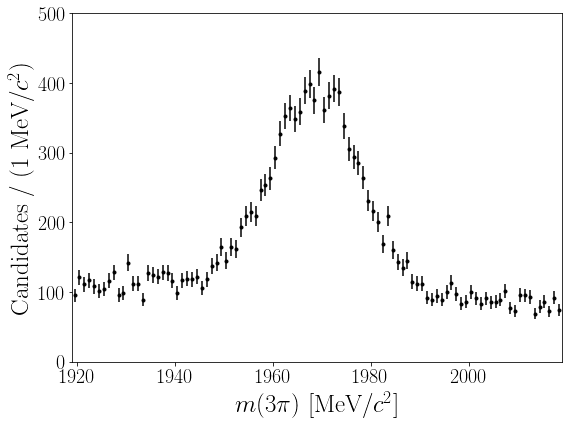

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/tau_M_all_data_strip_cutDeltaM_Ds_V8.pdf


In [5]:
fct.plot_hist_particle({name_data:df_Ds},'tau_M',
              n_bins = 100, mode_hist = False, colors='black')

## Fit on $m(3\pi)$ = gaussian (signal) + exponential (background)

### Initial conditions

In [6]:
n_events_tau_M = len(df_Ds)
initial_values_tau = {
    'mu_tau': {
        'value' : 1969.,
        'low': 1965.,
        'high': 1975.,     
    },
    'sigma_tau': {
        'value' : 9.4,
        'low': 5.,
        'high': 15.,
    },
    'n_bkg_tau': {
        'value' : n_events_tau_M*2/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'n_sig_tau': {
        'value' : n_events_tau_M/3,
        'low': 0,
        'high': n_events_tau_M,  
    },
    'lambda_tau': {
        'value' : -0.003,
        'low': -0.01,
        'high': -0.0001  
    }
}

### Parameters and pdf

In [7]:
obs_tau = zfit.Space("x", limits=(low_tau_M, high_tau_M))
zparams_tau = {}

for var_tau in initial_values_tau.keys():
    zparams_tau[var_tau] = zfit.Parameter(var_tau, initial_values_tau[var_tau]['value'], 
                                     initial_values_tau[var_tau]['low'], initial_values_tau[var_tau]['high'])

In [12]:
name_params_tau = {
    # Signal
    f'mu_tau':'$\mu_{S}$',
    f'sigma_tau':'$\sigma_{S}$',
    f'n_sig_tau':'$n_{S}$',
    # Combinatorial background
    f'n_bkg_tau':'$n_{bkg,c}$',
    f'lambda_tau':'$\\lambda_{bkg,c}$',
}

In [9]:
gaussian_tau = zfit.pdf.Gauss(zparams_tau["mu_tau"],zparams_tau["sigma_tau"],obs=obs_tau)
exponential_tau = zfit.pdf.Exponential(zparams_tau["lambda_tau"], obs=obs_tau)

gaussian_ext_tau = gaussian_tau.create_extended(zparams_tau["n_sig_tau"])
exp_ext_tau = exponential_tau.create_extended(zparams_tau["n_bkg_tau"])
model_tau = zfit.pdf.SumPDF([gaussian_ext_tau, exp_ext_tau]) # gauss is folded by frac

data_tau = zfit.Data.from_pandas(df_Ds['tau_M'],obs=obs_tau)

### Launch fit

In [10]:
import timeit
start = timeit.default_timer()
result_tau, params_tau = launch_fit(model_tau, data_tau, extended=True)
stop = timeit.default_timer()
print('Time to do the fit: ', stop - start) 


------------------------------------------------------------------
| FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
| EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
name            value    minuit_hesse         minuit_minos    at limit
----------  ---------  --------------  -------------------  ----------
n_sig_tau        6816     +/- 1.3e+02  -1.3e+02   +1.3

Result of the fit:

    ------------------------------------------------------------------
    | FCN = -7.151e+04              |     Ncalls=126 (126 total)     |
    | EDM = 4.61e-05 (Goal: 0.001)  |            up = 0.5            |
    ------------------------------------------------------------------
    |  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
    ------------------------------------------------------------------
    |     True      |     True      |   False   |       False        |
    ------------------------------------------------------------------
    | Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
    ------------------------------------------------------------------
    |     False     |     True      |   True    |   True    | False  |
    ------------------------------------------------------------------
    name            value    minuit_hesse         minuit_minos    at limit
    ----------  ---------  --------------  -------------------  ----------
    n_sig_tau        6816     +/- 1.3e+02  -1.3e+02   +1.3e+02       False
    n_bkg_tau        9932     +/- 1.4e+02  -1.4e+02   +1.4e+02       False
    mu_tau           1969     +/-    0.17  -   0.17   +   0.18       False
    sigma_tau       9.267     +/-    0.18  -   0.17   +   0.18       False
    lambda_tau  -0.003488     +/- 0.00037  -0.00037   +0.00037       False
    Time to do the fit:  2.776348260231316



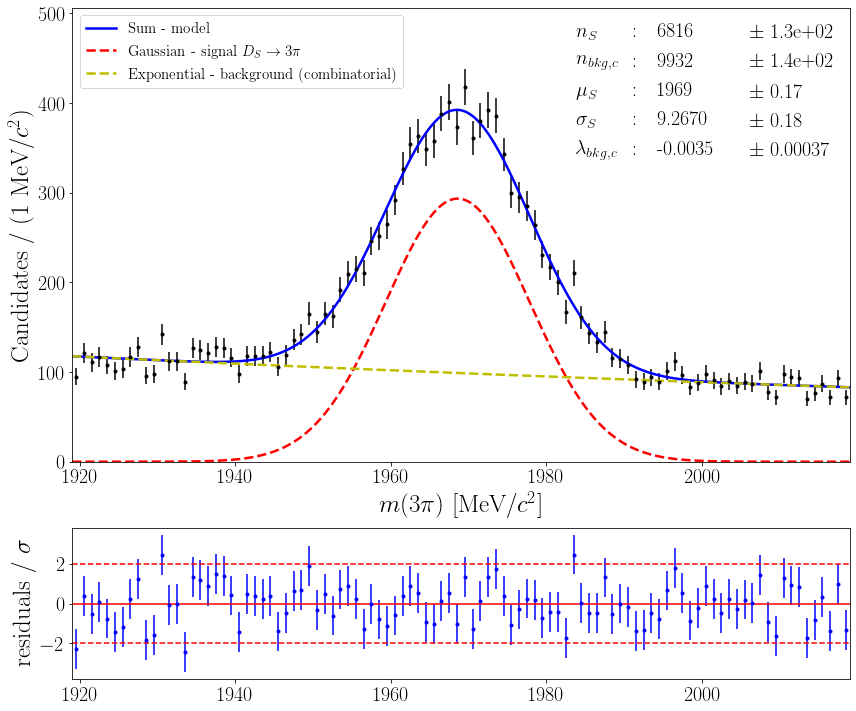

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_V8/tau_M_all_data_strip_cutDeltaM_Ds_V8_fit.pdf


In [15]:
plot_hist_fit_particle(df,'tau_M',models = [model_tau,gaussian_ext_tau,exp_ext_tau], 
                       name_models = ["", '$D_S \\to 3\pi$','(combinatorial)'], colors = ['b','r','y'],
                       obs=obs_tau, n_bins = 100,mode_hist = False, name_data=name_data, 
                      params=params_tau,name_params=name_params_tau, fontsize_leg=15.)

In [17]:
save_params(params_tau,name_data,True)

parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/all_data_strip_cutDeltaM_Ds_V8_params.json


## Calculate sWeights

We get
- $f_g(m)$, the signal Ds PDF
- $f_e(m)$, the background Ds PDF
Besides, our dataset is given by a list of events, each event is characterised by $m_{3\pi})$

We define the probability of the event $e$ being a $D_s$ by:
$$P\left(e = D_s\right)=\frac{f_g(m_{e, 3\pi})}{\sum_{event\ k}{\left(f_g(m_{k,3\pi})+f_e(m_{k, 3\pi})\right)}}$$

In [16]:
# Probability that the candidate is actually a Ds particle.
mass = df_Ds['tau_M']
probs = pd.DataFrame(dict(sig=gaussian_ext_tau.pdf(mass), bkg=exp_ext_tau.pdf(mass)))
probs = probs.div(probs.sum(axis=1), axis=0) # normalisation.......3

In [17]:
weights = splot.compute_sweights(probs)

In [ ]:
fct.dump_pickle(weights, name_data)

## Analyse of the sWeigth

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


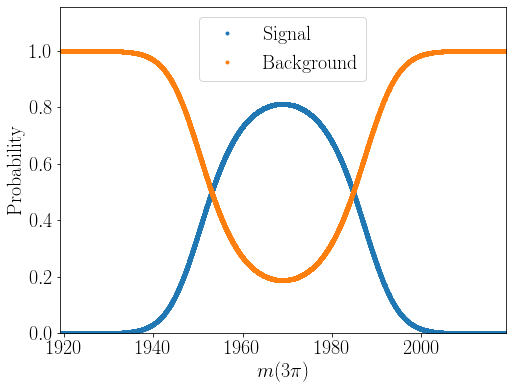

In [18]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, probs.sig,'.', label='Signal')
ax.plot(mass, probs.bkg,'.', label='Background')

plt.xlim(low_tau_M, high_tau_M) 
plt.xlabel('$m(3\pi)$',fontsize=20)
plt.ylabel('Probability',fontsize=20)

fct.fix_plot(ax)


plt.show()
plt.close()

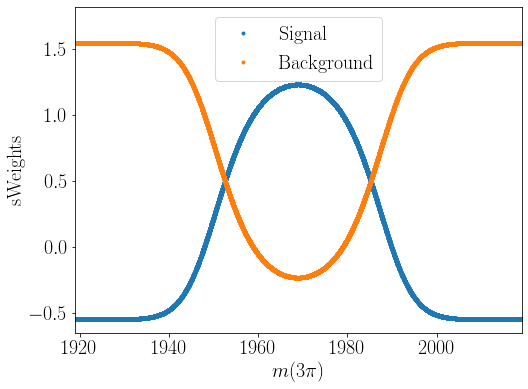

In [22]:
fig, ax = plt.subplots(figsize=(8,6))

ax.plot(mass, weights.sig,'.', label='Signal')
ax.plot(mass, weights.bkg,'.', label='Background')

plt.xlim(low_tau_M, high_tau_M) 
fct.fix_plot(ax, ymax=None)

plt.xlabel('$m(3\pi)$',fontsize=20)
plt.ylabel('sWeights',fontsize=20)

ymin, ymax = ax.get_ylim()
ax.set_ylim(ymin, ymax*1.1)

plt.show()
plt.close()

### Correlation between `B0_M`and `tau_M`.
Theoretically speaking, in order to apply the sWeights to 'B0_M', those two variables must not be correlated.

In [26]:
from scipy.stats import pearsonr

In [23]:
low_B0Ds = 5150.
high_B0Ds = 5360.

In [24]:
np.corrcoef(df_Ds['tau_M'], df_Ds['B0_M']) [0, 1]

0.04762547106585079

In [28]:
pearsonr(df_Ds['tau_M'], df_Ds['B0_M'])[0]

0.04762547106585078

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_V8/tau_M_vs_B0_M.pdf


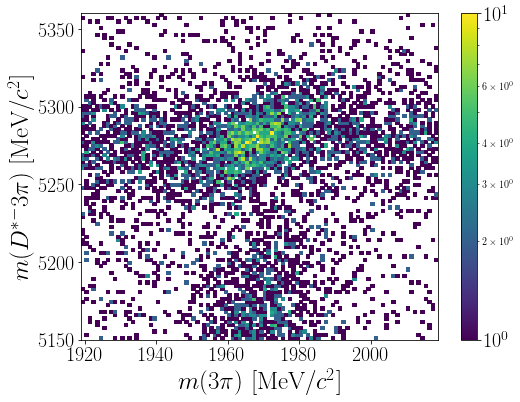

In [32]:
fct.plot_hist2d_particle(df_Ds,['tau_M','B0_M'],
            low=[low_tau_M, low_B0Ds],high=[high_tau_M, high_B0Ds], log_scale = True,
            name_folder=name_data)

## Save weights in a .root file
It is probably better than pickle, I'm quite stupid not to have thought about a root file first!

In [3]:
sWeights =  fct.retrieve_pickle(name_data)

In [4]:
fct.save_dataframe(sWeights, 'common_B0toDstDs_sWeights', 'sWeights')

In [5]:
sWeights.sig.to_numpy()

array([ 0.9461267 , -0.54960834, -0.49695778, ..., -0.13173394,
        1.15737414, -0.53810914])

In [6]:
df = fct.load_data(years, magnets, type_data='common', vars=['B0_M','tau_M', 'BDT'],
                            cut_DeltaM=True)
size_tau_M = 50.
mean_tau_M = 1969.
low_tau_M = mean_tau_M - size_tau_M
high_tau_M = mean_tau_M + size_tau_M
df_Ds = df.query(f"abs(tau_M-{mean_tau_M})<={size_tau_M}")

df_Ds['sWeight'] = sWeights.sig.to_numpy()

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/data_strip/all_data_strip.root


/afs/cern.ch/work/c/correian/miniconda/envs/bd2dst3pi_env/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [23]:
df_Ds

,B0_M,tau_M,BDT,sWeight
10,5037.392182,1957.902832,0.300843,0.946127
35,4287.192788,2017.977515,-0.319111,-0.549608
86,5292.956452,1939.093603,-0.084495,-0.496958
98,5184.331587,1964.436751,-0.453503,1.192611
145,4196.233788,2001.345797,0.158843,-0.529212
...,...,...,...,...
419867,4997.615231,1970.586207,0.227919,1.227064
419915,5012.438528,1959.252791,0.223470,1.020981
419947,5226.880905,1946.530054,0.171648,-0.131734
419958,4664.104416,1962.871685,-0.202893,1.157374


In [7]:
fct.save_dataframe(df_Ds, 'common_B0toDstDs', 'DecayTree')

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/all_data_strip_cutDeltaM_Ds_V8/BDT_vs_sWeight.pdf


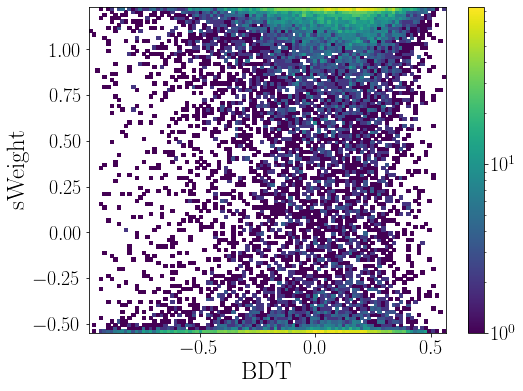

In [10]:
fct.plot_hist2d_particle(df_Ds,['BDT','sWeight'], 
                         log_scale=True, name_folder = name_data)